In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers


import sys
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
import random
import time 
import pandas as pd
import itertools
import tensorflow as tf

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import tensorflow as tf
from keras import backend as K

num_cores = 8
num_CPU = 1
num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : num_CPU,
                                        'GPU' : num_GPU}
                       )

session = tf.Session(config=config)
K.set_session(session)

### Merge categories

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
#from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']
Maintenance : 891
Feature Add : 330
Bug fix : 266
Documentation : 237
Clean up : 192
Refactoring : 111
Indentation : 48
Token Replace : 40
Source Control : 30
Cross : 24
Legal : 18
Debug : 10
Module Remove : 6
Module Move : 5
Rename : 5
Versioning : 4
Merge : 3
Initialization : 2
Internationalization : 1
Data : 1
Module Add : 1
1    1625
2     226
3      35
4       7
5       3
dtype: int64


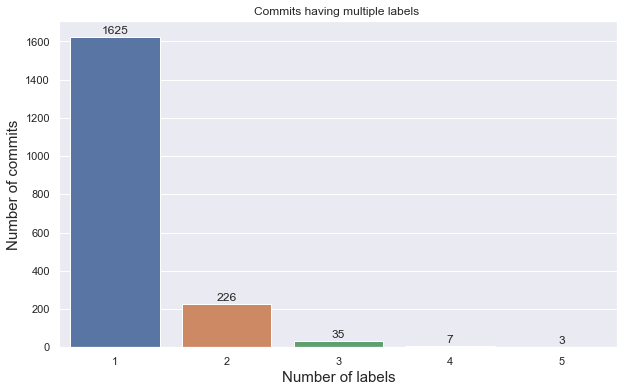

Corrective : 266
Adaptive : 237
Perfective : 1093
Implementation : 330
Non_functional : 70
Other : 34


In [8]:
df = pd.read_csv('data/commit_data_new.csv')
print(df.shape)

# convert string to list
from ast import literal_eval

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
print(df['categories'].values[0])
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

#tags_counts,target_columns = get_tag_counts_and_labels(df)
#print(target_columns)

# drop testing and build
new_df = drop_labels(df, ['Testing', 'Build'])
_ , target_col = get_tag_counts_and_labels(new_df)
multi_count = number_of_labels(new_df, target_col)

def group_labels_new(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # generate list of new_categories

    return new_df

new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Documentation'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'Maintenance','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Feature Add'], 'Implementation')
new_df = group_labels_new(new_df, ['Legal', 'Module Remove','Rename','Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Cross','Debug'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

In [9]:
# Drop 'Non-functional' and 'Other'

new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

Corrective : 266
Adaptive : 237
Perfective : 1093
Implementation : 330


1    1616
2     136
0     132
3      10
4       2
dtype: int64


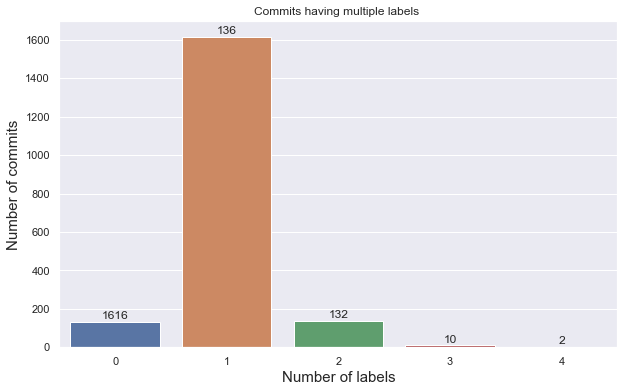

current number of samples: 1896
number of samples after drop:1616


In [10]:
# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

In [11]:
# Drop target col
new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
target_col = ['Corrective','Adaptive','Perfective','Implementation']

In [12]:
csha = new_df['Commit ID'].values
files = [c + '.json' for c in csha]
application_name = new_df['project name'].values
files_path = []
for project_name, c in zip(application_name,files):
    files_path.append(project_name + '_' + c)
print(files_path[0])

apache-avro_2df0775d2f368b326e3ac6442ce4850e3fe62edc.json


In [13]:
def parse_json(filepath, files):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []
    commit_ids = []
    # each commits
    #files = os.listdir(filepath)
    for path in files:
        commit_id = path.split("_")[1].split(".")[0]
        try:
            if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
                with open(filepath + path, encoding="utf8") as f:
                    data = json.load(f)
                    files_list = []
                    # each file in commits
                    for file in data['files']:
                        # parse only cluster file
                        for key in file.keys():
                            if re.match('^.*_cluster$', key):
                                actions_list = []
                                actions = file[key]['actions']
                                # each action in file
                                for action in actions:
                                    actions_list.append(action['root'])
                                files_list.append(actions_list)
                if len(files_list) != 0:
                    files_json.append(files_list)
                    commit_ids.append(commit_id)
        except FileNotFoundError as e: 
            continue 
    assert(len(commit_ids) == len(files_json))      
    # return
    return files_json, commit_ids

files = files_path
folder_path = 'D:\\Research\\AllFiles_Research\\'
all_files, csha = parse_json(folder_path, files)

In [16]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0].strip()
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()] + [
                        temp.split('INS ')[1].rsplit('to ')[-1].strip()
                    ]
                    for items in words:
                        items = items.split(':')[0].strip()
                        tempq.append(items)
                    if tempq[1] == 'TextElement' and tempq[-1] not in ['TagElement', 'TextElement']:
                        tempq[-1] = ''
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split('from ')[1].strip()
                    tempq.append('MOVE')
                    tempq.append(temp2.split(':')[0].strip())
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(':')[0].strip())
                    temp = '_'.join(tempq)
                temp = temp.replace(' ', '_')
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i
        i += 1
    return dic, files_data, counting

In [17]:
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))
print(len(dic))

472


In [18]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

## Data Preperation: 
Prepare data for embedding and training .

In [19]:
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from ast import literal_eval

In [20]:
def permutate_files(csha, training_data): 
    commits_dic = dict()
    for sha, training_file in zip(csha, training_data): 
        commits_dic[sha] = []
        if len(training_file) <= 5: 
            tmp_permutate = list(itertools.permutations(training_file))
            for permutated_file in tmp_permutate: 
                commits_dic[sha].append(list(permutated_file))
        else: 
            commits_dic[sha].append(training_file)
    return commits_dic

In [21]:
def expand_list(commits_labels_df):
    s= commits_labels_df.apply(lambda x: pd.Series(x['Files']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = "Files"
    commits_labels_df = commits_labels_df.drop("Files", axis=1) 
    commits_labels_df = commits_labels_df.join(s)
    return commits_labels_df

In [22]:
# merge csha and training data to a dataframe
commits_df = pd.DataFrame(data = [csha, training_data]).T
commits_df.columns = ["Commit ID", "Files"]
print(new_df.shape)

# merge two dataframe and drop some of labels
commits_labels_df = pd.merge(commits_df, new_df, on='Commit ID')

# split dataframe to train and test
msk = np.random.rand(len(commits_labels_df)) < 0.8
train_df = commits_labels_df[msk]
test_df = commits_labels_df[~msk]

# permutate train_df
permutate_train_dic = permutate_files(train_df['Commit ID'],train_df['Files'])
permutate_train_df = pd.DataFrame(list(permutate_train_dic.items()))
print(permutate_train_df.head())
permutate_train_df.columns = ['Commit ID','Files']
train_df = train_df.drop(["Files"], axis=1)
train_df['Files'] = permutate_train_df['Files'].values

# expanded train_df list
expanded_train_df = expand_list(train_df)

print('exp_train_df shape:',expanded_train_df.shape)
print('train_df shape:',train_df.shape)
print('test_df shape:',test_df.shape)

(1389, 29)
                                          0  \
0  2df0775d2f368b326e3ac6442ce4850e3fe62edc   
1  c2059f1524b50c120f655025efca958d61e6eb2b   
2  e117c10cef192ca4ab10ffec2132b7dbd34319fa   
3  24276d60ae65866018063933d5cb5faca6d202db   
4  55fbf047681affa637825c3108df1d1a80855063   

                                                   1  
0  [[INS_ImportDeclaration_CompilationUnit INS_Im...  
1  [[INS_ImportDeclaration_CompilationUnit INS_Im...  
2  [[INS_FieldDeclaration_TypeDeclaration INS_Fie...  
3                 [[INS_Modifier_MethodDeclaration]]  
4  [[INS_TagElement_Javadoc, INS_TagElement_Javad...  
exp_train_df shape: (6973, 30)
train_df shape: (955, 30)
test_df shape: (245, 30)


In [23]:
def concat_files_to_sentence(expanded_train_list): 
    concat_data = ""
    tmp_list = []
    for items in expanded_train_list:
        concat_data = " ".join(items)
        tmp_list.append(concat_data)
    return tmp_list
concat_train_data = concat_files_to_sentence(expanded_train_df["Files"])
concat_test_data = concat_files_to_sentence(test_df["Files"])
print(concat_train_data[0])
print("  ")
print(concat_test_data[0])

INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_TypeDeclaration_TypeDeclaration INS_TypeDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration MOVE_TypeDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration INS_Javadoc_MethodDeclaration UPDATE INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_Block_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration MOVE_FieldDeclaration INS_ParameterizedType_FieldDeclaration MOVE_FieldDeclaration MOVE_FieldDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_Singl

## Determine File Threshold 

<sample training data>:  ['INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_TypeDeclaration_TypeDeclaration INS_TypeDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration MOVE_TypeDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration MOVE_MethodDeclaration INS_Javadoc_MethodDeclaration UPDATE INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_Block_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration MOVE_FieldDeclaration INS_ParameterizedType_FieldDeclaration MOVE_FieldDeclaration MOVE_FieldDeclaration INS_SingleVariableDeclaration_

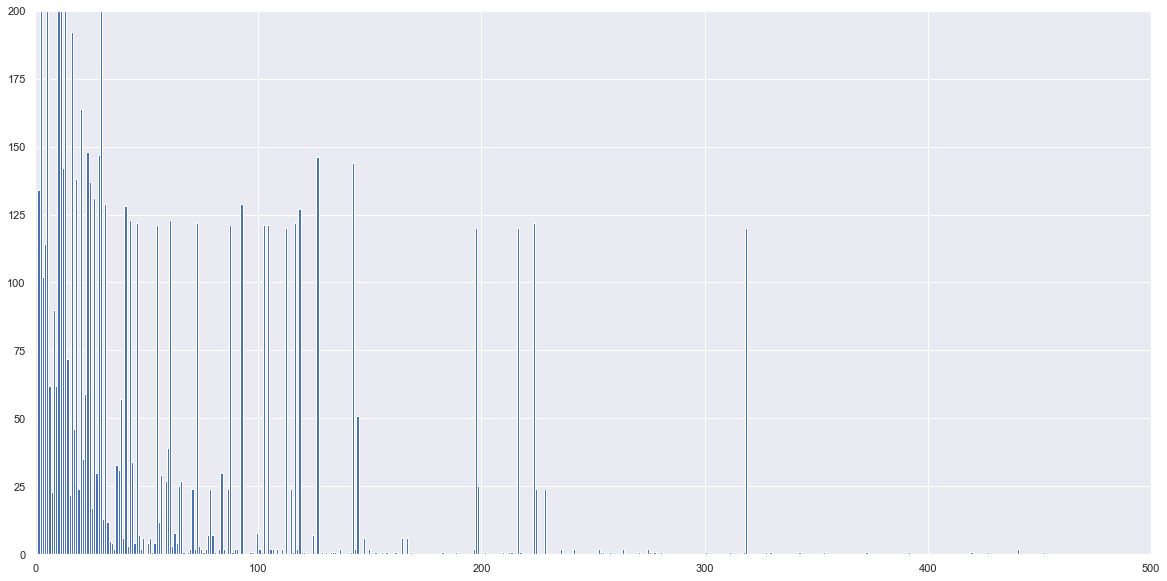

In [24]:
def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for item in training_data:
        seqlength_list.append(len(item.split()))
        if len(item.split()) >  max_root_len: 
            max_root_len = len(item.split())
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.xlim((0, 500))
    plt.ylim((0, 200))

max_seqlength, sequence_list = get_seqlength(concat_train_data)
print("<sample training data>: ", training_data[0])
plot_hist(sequence_list)

In [25]:
# getting file threshold
threshold = 0.95
number_of_actions = [len(item.split()) for item in concat_train_data]

def get_file_threshold(number_of_files, threshold = 0.95):
    '''
    get padding threshold for files dimension
    
    Args:
        number_of_files - array of the number of files in each commits
        threshold - drop all commits with its the number of files beyond this threshold
    Returns:
        padding threshold - number
    '''
    
    total_files = len(number_of_files)
    number_of_files = np.array(number_of_files)
    bincount = np.bincount(number_of_files)

    sum_file = 0
    for index, item in enumerate(bincount):
        sum_file += item
        #print(index,item)
        #print(sum_file)
        if sum_file > threshold*total_files:
            padding_files_threshold = index
            break
            
    return padding_files_threshold

length_threshold = get_file_threshold(number_of_actions, threshold)
print(length_threshold)

216


## Prepare Labels

In [27]:
expanded_train_df = expanded_train_df.drop(["Files"], axis=1)
test_df = test_df.drop(["Files"], axis=1)
expanded_train_df["Files"] = concat_train_data 
test_df["Files"] = concat_test_data 

In [28]:
expanded_train_df['len_seq'] = expanded_train_df.apply(lambda row: len(row['Files'].split()), axis = 1)
test_df['len_seq'] = test_df.apply(lambda row: len(row['Files'].split()), axis = 1)
expanded_train_df = expanded_train_df[expanded_train_df['len_seq'] <= length_threshold].reset_index(drop = True)
test_df = test_df[test_df['len_seq'] <= length_threshold].reset_index(drop = True)
print(test_df.columns)

Index(['Commit ID', 'project name', 'commit_message', 'Maintenance',
       'Feature Add', 'Bug fix', 'Documentation', 'Clean up', 'Refactoring',
       'Indentation', 'Token Replace', 'Source Control', 'Cross', 'Legal',
       'Debug', 'Module Remove', 'Module Move', 'Rename', 'Versioning',
       'Merge', 'Initialization', 'Internationalization', 'Data', 'Module Add',
       'categories', 'Corrective', 'Adaptive', 'Perfective', 'Implementation',
       'Files', 'len_seq'],
      dtype='object')


In [29]:
target_col =  ['Corrective', 'Adaptive','Perfective','Implementation']
y_train = expanded_train_df[target_col].values
y_test = test_df[target_col].values
print("traing labels shape: ", y_train.shape) 
print("test labels shape: ", y_test.shape)

traing labels shape:  (6634, 4)
test labels shape:  (234, 4)


## Tokenize and Pad data 
We tokenize the data and pad with the token <PAD/>.<br/> 

In [30]:
#Training 
train_docs = expanded_train_df['Files'].values
t_train = Tokenizer(filters = '', lower=False)
t_train.fit_on_texts(train_docs)

#Testing 
test_docs = test_df['Files'].values 
t_test = Tokenizer(filters = '', lower=False)
t_test.fit_on_texts(test_docs)

sequences_train = t_train.texts_to_sequences(train_docs)
sequences_test = t_test.texts_to_sequences(test_docs)
print(sequences_train[0])
print(sequences_test[0])

#Pad training data 
padded_seq_train = pad_sequences(sequences_train, maxlen=length_threshold + 1, padding="post", truncating="post")
print(padded_seq_train.shape)

#Pad testing data 
padded_seq_test = pad_sequences(sequences_test, maxlen=length_threshold + 1, padding="post", truncating="post")
print(padded_seq_test.shape)

[3, 3, 10, 123]
[13, 45]
(6634, 217)
(234, 217)


## Creating Testing and Training Set 

In [31]:
vocabulary_train = t_train.word_index
vocabulary_test = t_test.word_index 


vocabulary_inv_train = dict((v, k) for k, v in vocabulary_train.items())
vocabulary_inv_test = dict((v, k) for k, v in vocabulary_test.items())
vocabulary_inv_train[0] = "<PAD/>"
vocabulary_inv_test[0] = "<PAD/>"

In [32]:
X_train = padded_seq_train 
X_test = padded_seq_test
print(X_train[10, :])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(6634, 217)
(234, 217)
(6634, 4)
(234, 4)


### Embedding

In [33]:
def load_embedding(filename):
    """
    load embedding as python dictionary {root<str>: embeddings<np_array>}
    :param filename: embedding.txt 
    :return: dictionary object mapping root to embeddings 
    """
    if not os.path.exists(filename): 
        print("please run 'Stored Pre-Trained Embeddings Cell!'")
    else: 
        with open(filename, "r") as f: 
            lines = f.readlines()
            f.close()
            # create map of words to vectors 
            embedding = dict()
            for line in lines: 
                comp = line.split()
                # map of <str, numpy array> 
                embedding[comp[0]] = np.asarray(comp[1:], dtype='float32')
            return embedding 

In [34]:
pre_embed = load_embedding("embedding_genism_300_dic.txt")

In [35]:
X_train = np.stack([np.stack([pre_embed[vocabulary_inv_train[action]] for action in commit]) for commit in X_train])
X_test = np.stack([np.stack([pre_embed[vocabulary_inv_test[action]] for action in commit]) for commit in X_test])
print("x_train static shape:", X_train.shape)
print("x_test static shape:", X_test.shape)

x_train static shape: (6634, 217, 300)
x_test static shape: (234, 217, 300)


### CNN for text

In [36]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.metrics import *
from keras import regularizers
import warnings
import keras
warnings.filterwarnings('ignore')

In [37]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))
    print('Hamming_loss:', hamming_loss(y_test, predicted))

In [38]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


W0728 18:05:24.988074  1064 deprecation_wrapper.py:119] From C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 18:05:24.990068  1064 deprecation_wrapper.py:119] From C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 18:05:25.223557  1064 deprecation_wrapper.py:119] From C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0728 18:05:25.293193  1064 deprecation.py:506] From C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflo

Train on 6634 samples, validate on 234 samples
Epoch 1/30
 - 18s - loss: 0.9992 - acc: 0.5467 - val_loss: 0.9299 - val_acc: 0.6624
Epoch 2/30
 - 17s - loss: 0.9115 - acc: 0.6717 - val_loss: 0.8686 - val_acc: 0.6624
Epoch 3/30
 - 16s - loss: 0.6959 - acc: 0.6773 - val_loss: 0.7913 - val_acc: 0.6624
Epoch 4/30
 - 18s - loss: 0.6382 - acc: 0.6850 - val_loss: 0.7568 - val_acc: 0.6581
Epoch 5/30
 - 18s - loss: 0.5606 - acc: 0.7121 - val_loss: 0.7272 - val_acc: 0.6667
Epoch 6/30
 - 18s - loss: 0.4770 - acc: 0.7742 - val_loss: 0.7272 - val_acc: 0.6795
Epoch 7/30
 - 18s - loss: 0.4139 - acc: 0.8203 - val_loss: 0.7345 - val_acc: 0.7051
Epoch 8/30
 - 17s - loss: 0.3573 - acc: 0.8689 - val_loss: 0.7381 - val_acc: 0.7222
Epoch 9/30
 - 19s - loss: 0.3095 - acc: 0.9013 - val_loss: 0.7492 - val_acc: 0.6923
Epoch 10/30
 - 18s - loss: 0.2762 - acc: 0.9130 - val_loss: 0.7542 - val_acc: 0.6838
Epoch 11/30
 - 18s - loss: 0.2462 - acc: 0.9175 - val_loss: 0.7636 - val_acc: 0.6838
Epoch 12/30
 - 20s - loss: 

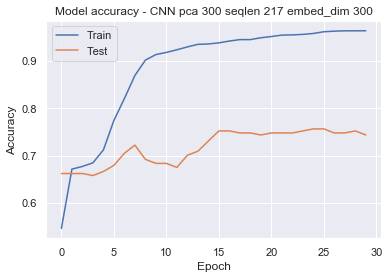

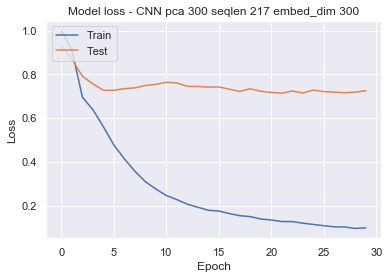

In [39]:
# hyparameters
model_type = "CNN-non-static"  # CNN-rand|CNN-non-static|CNN-static

# import functools
# top2_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=2)

# top2_acc.__name__ = 'top2_acc'

# Model Hyperparameters
embedding_dim = 300
filter_sizes = (5,5,5)
num_filters = 5
dropout_prob = (0.4, 0.4)
hidden_dims = 128

# Training parameters
batch_size = 256
num_epochs = 30 #50

sequence_length = length_threshold

# input
input_shape = (sequence_length + 1, embedding_dim)
model_input = Input(shape=input_shape)

z = model_input

#dropout layer
z = Dropout(dropout_prob[0])(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes: # Feature > Maintenance > Clean  up > Bug fix > 
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="same",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)

model_output = Dense(4, activation="softmax")(z)

model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer= optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                                                                     epsilon=None, decay=0.0, amsgrad=False), 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test), verbose=2, shuffle = False)
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy - CNN pca %s seqlen %s embed_dim %s'%((X_train.shape[2], X_train.shape[1], embedding_dim)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("./plot/CNN_pca%s_seqlen%s_embedding_dim_%s_acc.png"%(X_train.shape[2], X_train.shape[1],embedding_dim))
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - CNN pca %s seqlen %s embed_dim %s'%((X_train.shape[2], X_train.shape[1], embedding_dim)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("./plot/CNN_pca%s_seqlen%s_embedding_dim_%s_loss.png"%(X_train.shape[2], X_train.shape[1],embedding_dim))
plt.show()

In [40]:
y_pred = model.predict(X_test)

y_pred_bool = (y_pred > 0.5)

predictions = y_pred_bool.astype(int)
print_evaluation_scores(y_test, predictions)

Accuracy: 0.7435897435897436
F1-score macro: 0.49683808555167464
F1-score micro: 0.7499999999999999
F1-score weighted: 0.7360091271469583
Hamming_loss: 0.12393162393162394


### CNN for Text - PCA

In [41]:
def CNN_model(X_train, X_test, y_train, y_test):

    # hyparameters
    model_type = "CNN-non-static"  # CNN-rand|CNN-non-static|CNN-static

    # import functools
    # top2_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=2)

    # top2_acc.__name__ = 'top2_acc'

    # Model Hyperparameters
    embedding_dim = 300
    filter_sizes = (5,5,5)
    num_filters = 5
    dropout_prob = (0.4, 0.4)
    hidden_dims = 128

    # Training parameters
    batch_size = 256
    num_epochs = 50 #50

    sequence_length = length_threshold

    # input
    pca_shape = X_train.shape[2]
    # input_shape = (sequence_length + 1, embedding_dim)
    input_shape = (sequence_length + 1, pca_shape)
    model_input = Input(shape=input_shape)

    z = model_input

    #dropout layer
    z = Dropout(dropout_prob[0])(z)

    # Convolutional block
    conv_blocks = []
    for sz in filter_sizes: # Feature > Maintenance > Clean  up > Bug fix > 
        conv = Convolution1D(filters=num_filters,
                             kernel_size=sz,
                             padding="same",
                             activation="relu",
                             strides=1)(z)
        conv = MaxPooling1D(pool_size=2)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    z = Dropout(dropout_prob[1])(z)

    z = Dense(hidden_dims, activation="relu")(z)

    model_output = Dense(4, activation="softmax")(z)

    model = Model(model_input, model_output)
    model.compile(loss="categorical_crossentropy", optimizer= optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                                                                         epsilon=None, decay=0.0, amsgrad=False), 
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
              validation_data=(X_test, y_test), verbose=2, shuffle = False)
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy - CNN pca %s seqlen %s embed_dim %s'%((X_train.shape[2], X_train.shape[1], embedding_dim)))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig("./plot/CNN_pca%s_seqlen%s_embedding_dim_%s_acc.png"%(X_train.shape[2], X_train.shape[1],embedding_dim))
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - CNN pca %s seqlen %s embed_dim %s'%((X_train.shape[2], X_train.shape[1], embedding_dim)))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig("./plot/CNN_pca%s_seqlen%s_embedding_dim_%s_loss.png"%(X_train.shape[2], X_train.shape[1],embedding_dim))
    plt.show()

(6634, 217, 32)
(234, 217, 32)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 3s - loss: 1.0311 - acc: 0.5553 - val_loss: 1.0463 - val_acc: 0.6624
Epoch 2/50
 - 2s - loss: 1.0390 - acc: 0.6290 - val_loss: 1.0096 - val_acc: 0.6581
Epoch 3/50
 - 2s - loss: 0.8222 - acc: 0.6687 - val_loss: 0.9308 - val_acc: 0.6581
Epoch 4/50
 - 2s - loss: 0.8074 - acc: 0.6812 - val_loss: 0.8899 - val_acc: 0.6581
Epoch 5/50
 - 2s - loss: 0.7655 - acc: 0.6815 - val_loss: 0.8720 - val_acc: 0.6581
Epoch 6/50
 - 2s - loss: 0.7339 - acc: 0.6812 - val_loss: 0.8598 - val_acc: 0.6581
Epoch 7/50
 - 2s - loss: 0.7141 - acc: 0.6797 - val_loss: 0.8572 - val_acc: 0.6581
Epoch 8/50
 - 2s - loss: 0.6871 - acc: 0.6815 - val_loss: 0.8558 - val_acc: 0.6581
Epoch 9/50
 - 2s - loss: 0.6554 - acc: 0.7046 - val_loss: 0.8596 - val_acc: 0.6496
Epoch 10/50
 - 2s - loss: 0.6292 - acc: 0.7187 - val_loss: 0.8654 - val_acc: 0.6453
Epoch 11/50
 - 2s - loss: 0.6052 - acc: 0.7335 - val_loss: 0.8719 - val_acc: 0.6368
Epoch 1

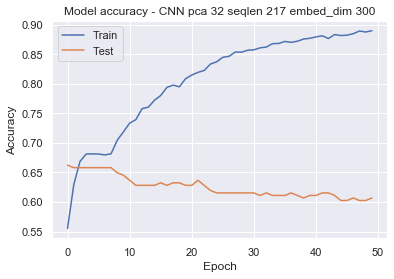

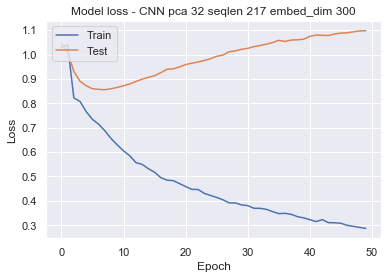

(6634, 217, 36)
(234, 217, 36)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 4s - loss: 1.0200 - acc: 0.5790 - val_loss: 1.0345 - val_acc: 0.6624
Epoch 2/50
 - 3s - loss: 1.0082 - acc: 0.6373 - val_loss: 1.0036 - val_acc: 0.6624
Epoch 3/50
 - 3s - loss: 0.8417 - acc: 0.6690 - val_loss: 0.9339 - val_acc: 0.6624
Epoch 4/50
 - 3s - loss: 0.8173 - acc: 0.6859 - val_loss: 0.9040 - val_acc: 0.6624
Epoch 5/50
 - 3s - loss: 0.7864 - acc: 0.6827 - val_loss: 0.8831 - val_acc: 0.6581
Epoch 6/50
 - 3s - loss: 0.7526 - acc: 0.6821 - val_loss: 0.8731 - val_acc: 0.6581
Epoch 7/50
 - 3s - loss: 0.7216 - acc: 0.6841 - val_loss: 0.8640 - val_acc: 0.6538
Epoch 8/50
 - 3s - loss: 0.6979 - acc: 0.6925 - val_loss: 0.8631 - val_acc: 0.6538
Epoch 9/50
 - 3s - loss: 0.6775 - acc: 0.7026 - val_loss: 0.8696 - val_acc: 0.6538
Epoch 10/50
 - 3s - loss: 0.6478 - acc: 0.7162 - val_loss: 0.8739 - val_acc: 0.6368
Epoch 11/50
 - 3s - loss: 0.6234 - acc: 0.7223 - val_loss: 0.8814 - val_acc: 0.6410
Epoch 1

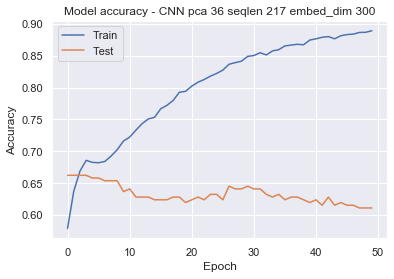

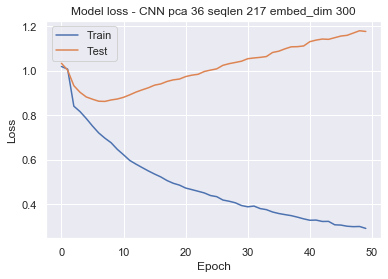

(6634, 217, 40)
(234, 217, 40)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 4s - loss: 1.0161 - acc: 0.5791 - val_loss: 1.0387 - val_acc: 0.6624
Epoch 2/50
 - 3s - loss: 1.0215 - acc: 0.6497 - val_loss: 1.0246 - val_acc: 0.6624
Epoch 3/50
 - 3s - loss: 0.8204 - acc: 0.6694 - val_loss: 0.9448 - val_acc: 0.6624
Epoch 4/50
 - 3s - loss: 0.8188 - acc: 0.6834 - val_loss: 0.9100 - val_acc: 0.6624
Epoch 5/50
 - 3s - loss: 0.7869 - acc: 0.6819 - val_loss: 0.8923 - val_acc: 0.6581
Epoch 6/50
 - 3s - loss: 0.7521 - acc: 0.6821 - val_loss: 0.8725 - val_acc: 0.6581
Epoch 7/50
 - 3s - loss: 0.7226 - acc: 0.6869 - val_loss: 0.8616 - val_acc: 0.6581
Epoch 8/50
 - 3s - loss: 0.6971 - acc: 0.6925 - val_loss: 0.8591 - val_acc: 0.6581
Epoch 9/50
 - 3s - loss: 0.6681 - acc: 0.7005 - val_loss: 0.8609 - val_acc: 0.6581
Epoch 10/50
 - 3s - loss: 0.6512 - acc: 0.7103 - val_loss: 0.8636 - val_acc: 0.6581
Epoch 11/50
 - 3s - loss: 0.6221 - acc: 0.7193 - val_loss: 0.8711 - val_acc: 0.6581
Epoch 1

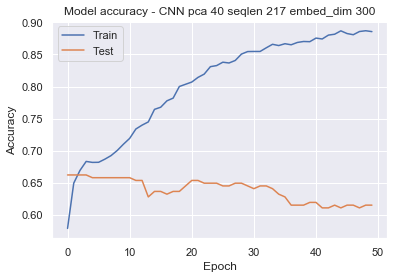

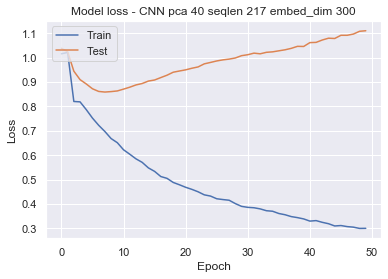

(6634, 217, 44)
(234, 217, 44)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 4s - loss: 0.9915 - acc: 0.5965 - val_loss: 1.0285 - val_acc: 0.6624
Epoch 2/50
 - 3s - loss: 1.0051 - acc: 0.6492 - val_loss: 0.9939 - val_acc: 0.6581
Epoch 3/50
 - 3s - loss: 0.8029 - acc: 0.6690 - val_loss: 0.9052 - val_acc: 0.6624
Epoch 4/50
 - 3s - loss: 0.8110 - acc: 0.6825 - val_loss: 0.8788 - val_acc: 0.6581
Epoch 5/50
 - 3s - loss: 0.7552 - acc: 0.6821 - val_loss: 0.8612 - val_acc: 0.6581
Epoch 6/50
 - 3s - loss: 0.7213 - acc: 0.6819 - val_loss: 0.8602 - val_acc: 0.6581
Epoch 7/50
 - 3s - loss: 0.6908 - acc: 0.6868 - val_loss: 0.8614 - val_acc: 0.6538
Epoch 8/50
 - 3s - loss: 0.6623 - acc: 0.7008 - val_loss: 0.8663 - val_acc: 0.6410
Epoch 9/50
 - 3s - loss: 0.6311 - acc: 0.7174 - val_loss: 0.8755 - val_acc: 0.6239
Epoch 10/50
 - 3s - loss: 0.5998 - acc: 0.7350 - val_loss: 0.8877 - val_acc: 0.6239
Epoch 11/50
 - 3s - loss: 0.5797 - acc: 0.7397 - val_loss: 0.8988 - val_acc: 0.6239
Epoch 1

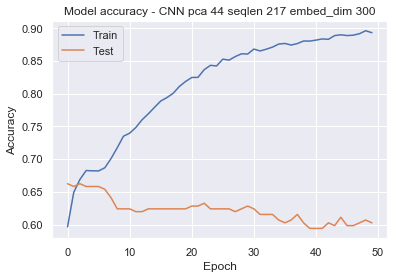

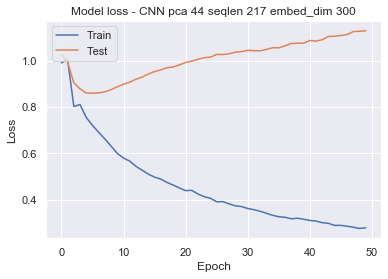

(6634, 217, 48)
(234, 217, 48)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 4s - loss: 0.9757 - acc: 0.5846 - val_loss: 0.9993 - val_acc: 0.6624
Epoch 2/50
 - 3s - loss: 1.0203 - acc: 0.6519 - val_loss: 0.9899 - val_acc: 0.6624
Epoch 3/50
 - 3s - loss: 0.8338 - acc: 0.6690 - val_loss: 0.9265 - val_acc: 0.6624
Epoch 4/50
 - 3s - loss: 0.8103 - acc: 0.6824 - val_loss: 0.8927 - val_acc: 0.6624
Epoch 5/50
 - 3s - loss: 0.8035 - acc: 0.6854 - val_loss: 0.8871 - val_acc: 0.6624
Epoch 6/50
 - 3s - loss: 0.7606 - acc: 0.6853 - val_loss: 0.8655 - val_acc: 0.6624
Epoch 7/50
 - 3s - loss: 0.7280 - acc: 0.6816 - val_loss: 0.8564 - val_acc: 0.6624
Epoch 8/50
 - 3s - loss: 0.7097 - acc: 0.6794 - val_loss: 0.8575 - val_acc: 0.6624
Epoch 9/50
 - 3s - loss: 0.6795 - acc: 0.6892 - val_loss: 0.8595 - val_acc: 0.6581
Epoch 10/50
 - 3s - loss: 0.6528 - acc: 0.7094 - val_loss: 0.8635 - val_acc: 0.6538
Epoch 11/50
 - 3s - loss: 0.6221 - acc: 0.7184 - val_loss: 0.8709 - val_acc: 0.6453
Epoch 1

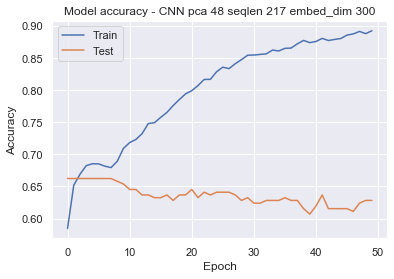

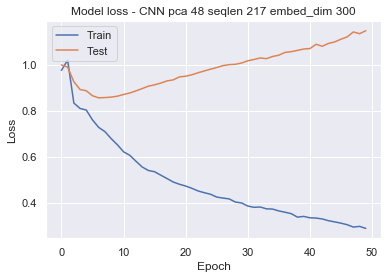

(6634, 217, 52)
(234, 217, 52)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 4s - loss: 1.0191 - acc: 0.5219 - val_loss: 1.0042 - val_acc: 0.6624
Epoch 2/50
 - 3s - loss: 0.9860 - acc: 0.6675 - val_loss: 0.9791 - val_acc: 0.6624
Epoch 3/50
 - 3s - loss: 0.8159 - acc: 0.6690 - val_loss: 0.9049 - val_acc: 0.6624
Epoch 4/50
 - 3s - loss: 0.8078 - acc: 0.6752 - val_loss: 0.8762 - val_acc: 0.6624
Epoch 5/50
 - 3s - loss: 0.7772 - acc: 0.6834 - val_loss: 0.8685 - val_acc: 0.6581
Epoch 6/50
 - 3s - loss: 0.7395 - acc: 0.6812 - val_loss: 0.8555 - val_acc: 0.6581
Epoch 7/50
 - 3s - loss: 0.7040 - acc: 0.6913 - val_loss: 0.8569 - val_acc: 0.6581
Epoch 8/50
 - 3s - loss: 0.6735 - acc: 0.7015 - val_loss: 0.8603 - val_acc: 0.6581
Epoch 9/50
 - 3s - loss: 0.6482 - acc: 0.7077 - val_loss: 0.8664 - val_acc: 0.6581
Epoch 10/50
 - 3s - loss: 0.6200 - acc: 0.7207 - val_loss: 0.8736 - val_acc: 0.6453
Epoch 11/50
 - 3s - loss: 0.5929 - acc: 0.7335 - val_loss: 0.8806 - val_acc: 0.6368
Epoch 1

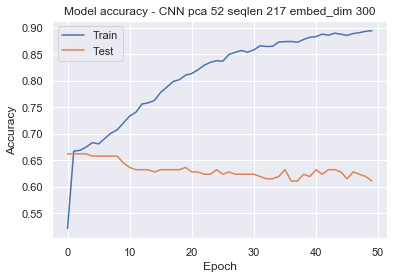

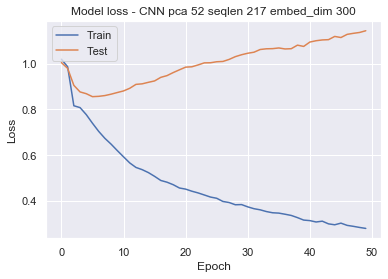

(6634, 217, 56)
(234, 217, 56)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 5s - loss: 0.9523 - acc: 0.5995 - val_loss: 0.9845 - val_acc: 0.6624
Epoch 2/50
 - 4s - loss: 0.9865 - acc: 0.6593 - val_loss: 0.9610 - val_acc: 0.6581
Epoch 3/50
 - 4s - loss: 0.8261 - acc: 0.6687 - val_loss: 0.9024 - val_acc: 0.6581
Epoch 4/50
 - 4s - loss: 0.7953 - acc: 0.6838 - val_loss: 0.8769 - val_acc: 0.6581
Epoch 5/50
 - 4s - loss: 0.7677 - acc: 0.6834 - val_loss: 0.8637 - val_acc: 0.6581
Epoch 6/50
 - 4s - loss: 0.7360 - acc: 0.6819 - val_loss: 0.8563 - val_acc: 0.6581
Epoch 7/50
 - 4s - loss: 0.7038 - acc: 0.6871 - val_loss: 0.8551 - val_acc: 0.6538
Epoch 8/50
 - 4s - loss: 0.6739 - acc: 0.6978 - val_loss: 0.8574 - val_acc: 0.6538
Epoch 9/50
 - 4s - loss: 0.6498 - acc: 0.7104 - val_loss: 0.8623 - val_acc: 0.6453
Epoch 10/50
 - 4s - loss: 0.6172 - acc: 0.7275 - val_loss: 0.8685 - val_acc: 0.6368
Epoch 11/50
 - 4s - loss: 0.6021 - acc: 0.7299 - val_loss: 0.8764 - val_acc: 0.6325
Epoch 1

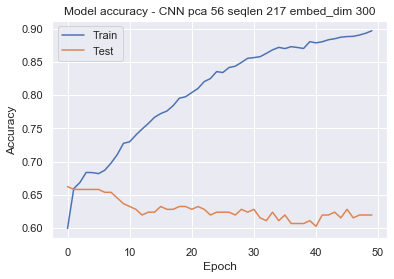

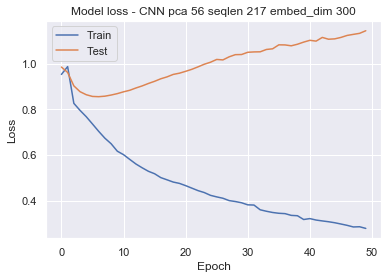

(6634, 217, 60)
(234, 217, 60)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 5s - loss: 0.9954 - acc: 0.6045 - val_loss: 1.0195 - val_acc: 0.6624
Epoch 2/50
 - 4s - loss: 1.0181 - acc: 0.6483 - val_loss: 0.9923 - val_acc: 0.6581
Epoch 3/50
 - 4s - loss: 0.8283 - acc: 0.6685 - val_loss: 0.9205 - val_acc: 0.6581
Epoch 4/50
 - 4s - loss: 0.7956 - acc: 0.6851 - val_loss: 0.8906 - val_acc: 0.6581
Epoch 5/50
 - 4s - loss: 0.7704 - acc: 0.6833 - val_loss: 0.8827 - val_acc: 0.6581
Epoch 6/50
 - 4s - loss: 0.7395 - acc: 0.6881 - val_loss: 0.8735 - val_acc: 0.6581
Epoch 7/50
 - 4s - loss: 0.7034 - acc: 0.6978 - val_loss: 0.8711 - val_acc: 0.6496
Epoch 8/50
 - 4s - loss: 0.6700 - acc: 0.7107 - val_loss: 0.8727 - val_acc: 0.6496
Epoch 9/50
 - 4s - loss: 0.6459 - acc: 0.7235 - val_loss: 0.8782 - val_acc: 0.6496
Epoch 10/50
 - 4s - loss: 0.6281 - acc: 0.7291 - val_loss: 0.8854 - val_acc: 0.6496
Epoch 11/50
 - 4s - loss: 0.6063 - acc: 0.7341 - val_loss: 0.8933 - val_acc: 0.6496
Epoch 1

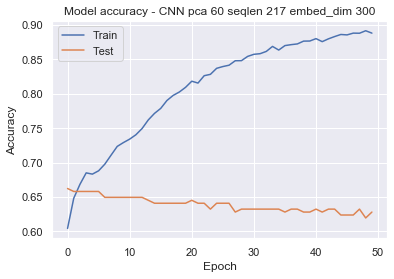

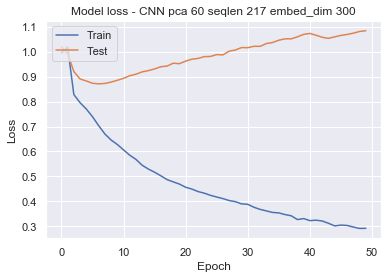

(6634, 217, 64)
(234, 217, 64)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 6s - loss: 0.9981 - acc: 0.5891 - val_loss: 1.0118 - val_acc: 0.6624
Epoch 2/50
 - 4s - loss: 1.0261 - acc: 0.6411 - val_loss: 0.9965 - val_acc: 0.6624
Epoch 3/50
 - 4s - loss: 0.8179 - acc: 0.6688 - val_loss: 0.9193 - val_acc: 0.6624
Epoch 4/50
 - 4s - loss: 0.8113 - acc: 0.6841 - val_loss: 0.8988 - val_acc: 0.6581
Epoch 5/50
 - 4s - loss: 0.7754 - acc: 0.6838 - val_loss: 0.8845 - val_acc: 0.6581
Epoch 6/50
 - 4s - loss: 0.7339 - acc: 0.6851 - val_loss: 0.8721 - val_acc: 0.6581
Epoch 7/50
 - 4s - loss: 0.7181 - acc: 0.6908 - val_loss: 0.8741 - val_acc: 0.6538
Epoch 8/50
 - 4s - loss: 0.6920 - acc: 0.7006 - val_loss: 0.8758 - val_acc: 0.6453
Epoch 9/50
 - 4s - loss: 0.6592 - acc: 0.7110 - val_loss: 0.8784 - val_acc: 0.6368
Epoch 10/50
 - 4s - loss: 0.6252 - acc: 0.7252 - val_loss: 0.8863 - val_acc: 0.6368
Epoch 11/50
 - 4s - loss: 0.6060 - acc: 0.7311 - val_loss: 0.8949 - val_acc: 0.6368
Epoch 1

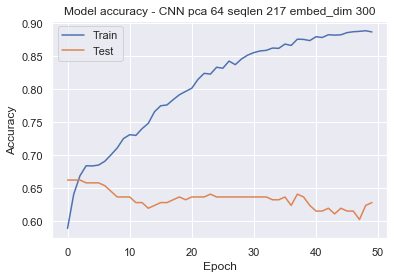

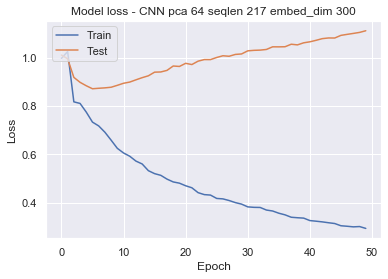

(6634, 217, 68)
(234, 217, 68)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 5s - loss: 0.9748 - acc: 0.5378 - val_loss: 0.9916 - val_acc: 0.6624
Epoch 2/50
 - 4s - loss: 0.9849 - acc: 0.6669 - val_loss: 0.9837 - val_acc: 0.6581
Epoch 3/50
 - 4s - loss: 0.8121 - acc: 0.6690 - val_loss: 0.9019 - val_acc: 0.6581
Epoch 4/50
 - 4s - loss: 0.7935 - acc: 0.6825 - val_loss: 0.8754 - val_acc: 0.6581
Epoch 5/50
 - 4s - loss: 0.7571 - acc: 0.6836 - val_loss: 0.8619 - val_acc: 0.6581
Epoch 6/50
 - 4s - loss: 0.7211 - acc: 0.6932 - val_loss: 0.8588 - val_acc: 0.6581
Epoch 7/50
 - 4s - loss: 0.6795 - acc: 0.6976 - val_loss: 0.8597 - val_acc: 0.6581
Epoch 8/50
 - 4s - loss: 0.6532 - acc: 0.7085 - val_loss: 0.8654 - val_acc: 0.6581
Epoch 9/50
 - 4s - loss: 0.6330 - acc: 0.7156 - val_loss: 0.8721 - val_acc: 0.6496
Epoch 10/50
 - 4s - loss: 0.6052 - acc: 0.7270 - val_loss: 0.8784 - val_acc: 0.6453
Epoch 11/50
 - 4s - loss: 0.5836 - acc: 0.7364 - val_loss: 0.8877 - val_acc: 0.6368
Epoch 1

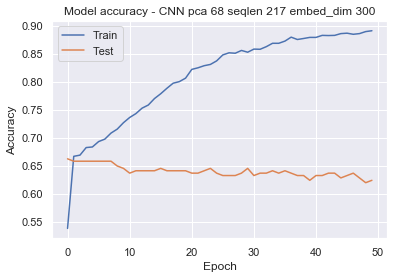

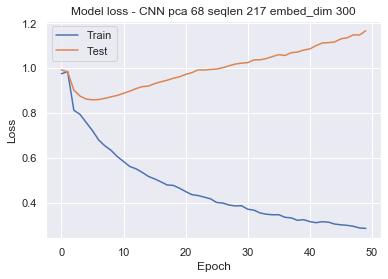

(6634, 217, 72)
(234, 217, 72)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 6s - loss: 0.9873 - acc: 0.5746 - val_loss: 1.0115 - val_acc: 0.6624
Epoch 2/50
 - 4s - loss: 1.0219 - acc: 0.6596 - val_loss: 1.0050 - val_acc: 0.6624
Epoch 3/50
 - 4s - loss: 0.8112 - acc: 0.6693 - val_loss: 0.9193 - val_acc: 0.6624
Epoch 4/50
 - 4s - loss: 0.8051 - acc: 0.6845 - val_loss: 0.9017 - val_acc: 0.6624
Epoch 5/50
 - 4s - loss: 0.7719 - acc: 0.6819 - val_loss: 0.8923 - val_acc: 0.6581
Epoch 6/50
 - 4s - loss: 0.7302 - acc: 0.6898 - val_loss: 0.8793 - val_acc: 0.6581
Epoch 7/50
 - 4s - loss: 0.6926 - acc: 0.7059 - val_loss: 0.8746 - val_acc: 0.6496
Epoch 8/50
 - 4s - loss: 0.6640 - acc: 0.7113 - val_loss: 0.8746 - val_acc: 0.6496
Epoch 9/50
 - 4s - loss: 0.6414 - acc: 0.7234 - val_loss: 0.8785 - val_acc: 0.6453
Epoch 10/50
 - 4s - loss: 0.6183 - acc: 0.7284 - val_loss: 0.8827 - val_acc: 0.6368
Epoch 11/50
 - 4s - loss: 0.5975 - acc: 0.7350 - val_loss: 0.8919 - val_acc: 0.6325
Epoch 1

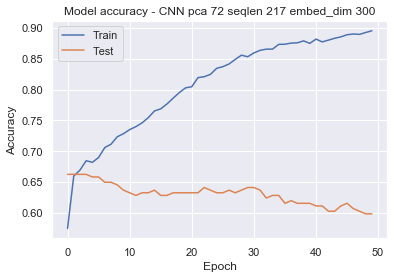

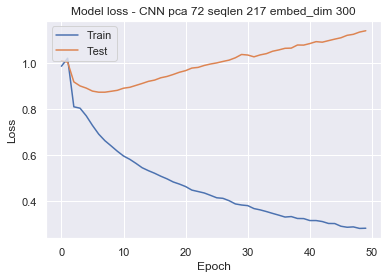

(6634, 217, 76)
(234, 217, 76)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 6s - loss: 0.9785 - acc: 0.5715 - val_loss: 0.9850 - val_acc: 0.6624
Epoch 2/50
 - 5s - loss: 0.9893 - acc: 0.6678 - val_loss: 0.9861 - val_acc: 0.6581
Epoch 3/50
 - 5s - loss: 0.8167 - acc: 0.6690 - val_loss: 0.9180 - val_acc: 0.6581
Epoch 4/50
 - 5s - loss: 0.8071 - acc: 0.6828 - val_loss: 0.9005 - val_acc: 0.6581
Epoch 5/50
 - 5s - loss: 0.7766 - acc: 0.6831 - val_loss: 0.8876 - val_acc: 0.6581
Epoch 6/50
 - 5s - loss: 0.7400 - acc: 0.6872 - val_loss: 0.8758 - val_acc: 0.6581
Epoch 7/50
 - 5s - loss: 0.7161 - acc: 0.6963 - val_loss: 0.8761 - val_acc: 0.6581
Epoch 8/50
 - 5s - loss: 0.6896 - acc: 0.7005 - val_loss: 0.8735 - val_acc: 0.6581
Epoch 9/50
 - 5s - loss: 0.6630 - acc: 0.7112 - val_loss: 0.8780 - val_acc: 0.6538
Epoch 10/50
 - 5s - loss: 0.6394 - acc: 0.7201 - val_loss: 0.8832 - val_acc: 0.6453
Epoch 11/50
 - 5s - loss: 0.6206 - acc: 0.7336 - val_loss: 0.8889 - val_acc: 0.6410
Epoch 1

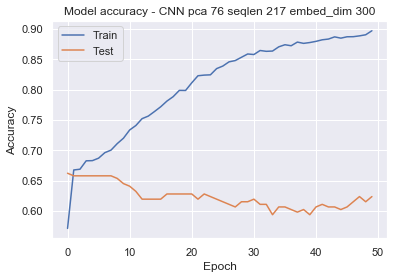

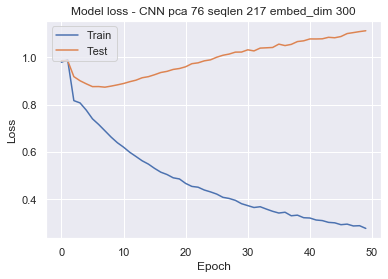

(6634, 217, 80)
(234, 217, 80)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 9s - loss: 0.9858 - acc: 0.5197 - val_loss: 0.9548 - val_acc: 0.6624
Epoch 2/50
 - 5s - loss: 0.9844 - acc: 0.6688 - val_loss: 0.9706 - val_acc: 0.6624
Epoch 3/50
 - 5s - loss: 0.8170 - acc: 0.6690 - val_loss: 0.9076 - val_acc: 0.6624
Epoch 4/50
 - 5s - loss: 0.8268 - acc: 0.6705 - val_loss: 0.8903 - val_acc: 0.6624
Epoch 5/50
 - 5s - loss: 0.7915 - acc: 0.6807 - val_loss: 0.8693 - val_acc: 0.6624
Epoch 6/50
 - 5s - loss: 0.7796 - acc: 0.6859 - val_loss: 0.8584 - val_acc: 0.6624
Epoch 7/50
 - 5s - loss: 0.7607 - acc: 0.6839 - val_loss: 0.8533 - val_acc: 0.6624
Epoch 8/50
 - 5s - loss: 0.7111 - acc: 0.6869 - val_loss: 0.8457 - val_acc: 0.6624
Epoch 9/50
 - 5s - loss: 0.6796 - acc: 0.7024 - val_loss: 0.8467 - val_acc: 0.6624
Epoch 10/50
 - 5s - loss: 0.6548 - acc: 0.7092 - val_loss: 0.8493 - val_acc: 0.6581
Epoch 11/50
 - 5s - loss: 0.6288 - acc: 0.7213 - val_loss: 0.8533 - val_acc: 0.6496
Epoch 1

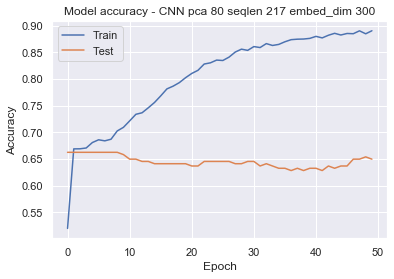

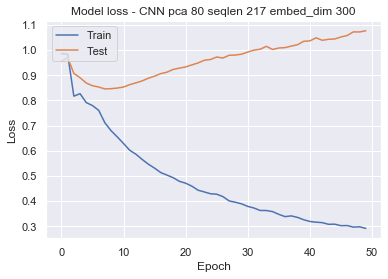

(6634, 217, 84)
(234, 217, 84)
Train on 6634 samples, validate on 234 samples
Epoch 1/50
 - 6s - loss: 1.0055 - acc: 0.5395 - val_loss: 0.9726 - val_acc: 0.6624
Epoch 2/50
 - 5s - loss: 1.0020 - acc: 0.6688 - val_loss: 0.9860 - val_acc: 0.6624
Epoch 3/50
 - 5s - loss: 0.8232 - acc: 0.6691 - val_loss: 0.9144 - val_acc: 0.6624
Epoch 4/50
 - 5s - loss: 0.8219 - acc: 0.6815 - val_loss: 0.8938 - val_acc: 0.6581
Epoch 5/50
 - 5s - loss: 0.8048 - acc: 0.6845 - val_loss: 0.8785 - val_acc: 0.6581
Epoch 6/50
 - 5s - loss: 0.7614 - acc: 0.6841 - val_loss: 0.8745 - val_acc: 0.6581
Epoch 7/50
 - 5s - loss: 0.7263 - acc: 0.6961 - val_loss: 0.8702 - val_acc: 0.6538
Epoch 8/50
 - 5s - loss: 0.6925 - acc: 0.7038 - val_loss: 0.8710 - val_acc: 0.6538
Epoch 9/50
 - 5s - loss: 0.6726 - acc: 0.7157 - val_loss: 0.8758 - val_acc: 0.6410
Epoch 10/50
 - 5s - loss: 0.6517 - acc: 0.7264 - val_loss: 0.8806 - val_acc: 0.6410
Epoch 11/50
 - 5s - loss: 0.6229 - acc: 0.7395 - val_loss: 0.8896 - val_acc: 0.6368
Epoch 1

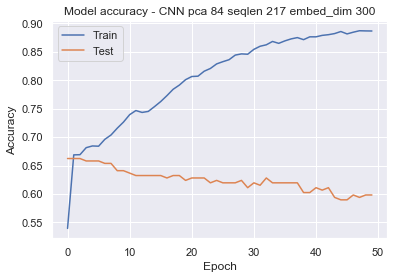

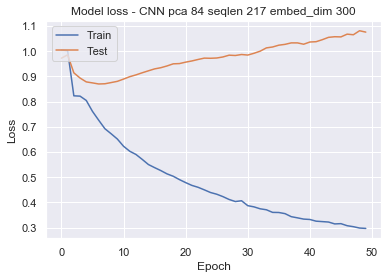

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
def pca_transform(X_train, dimension):
    row_dimension = X_train.shape[1]
    pca = PCA(n_components=dimension)

    X_train_new = []

    for item in X_train:
        X_train_new.append(pca.fit_transform(item))

    X_train_new = np.asarray(X_train_new)

    return X_train_new

for pca_dim in range(32, 196, 4):
    print('=====================================================================')
    X_train_new = pca_transform(X_train,pca_dim)
    X_test_new = pca_transform(X_test, pca_dim)

    print(X_train_new.shape)
    print(X_test_new.shape)

    CNN_model(X_train_new, X_test_new, y_train, y_test)